In [1]:
import sys, os
import numpy as np

from analyze_features import load_feature_stats
from utils import roi_utils
from model_fitting import initialize_fitting 
from analyze_fits import analyze_gabor_params

import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import cmocean

from plotting import load_fits, plot_utils, summary_plots

In [4]:
# Load everything

models = initialize_fitting.get_prf_models(which_grid=5)
n_prfs = len(models)
feature_type='gabor_solo'

mean, var, covar = \
        load_feature_stats.load_feature_stats(feature_type, subject='all')
corr, discrim, nsamp, names, signed_names = \
        load_feature_stats.load_feature_semantic_corrs(feature_type, subject='all')
partial_corr, partial_nsamp, partial_names, partial_signed_names = \
        load_feature_stats.load_feature_semantic_partial_corrs(feature_type, subject='all')

n_total_discrim_types = corr.shape[2]
n_partial_discrim_types = partial_corr.shape[2]

In [5]:
# Gather information about the gabor feature channels
sf_unique, ori_unique = analyze_gabor_params.get_gabor_feature_info(n_ori=12, n_sf=8)
n_sf = len(sf_unique)
n_ori = len(ori_unique)
ori_inds_list = np.tile(np.arange(0,n_ori), [n_sf,])
sf_inds_list = np.repeat(np.arange(0,n_sf), n_ori)

mean_reshaped = np.reshape(mean, [n_ori, n_sf, n_prfs], order = 'F')
var_reshaped = np.reshape(var, [n_ori, n_sf, n_prfs], order = 'F')
 
corr_reshaped = np.reshape(corr, [n_ori, n_sf, n_prfs, n_total_discrim_types], order='F')
discrim_reshaped = np.reshape(discrim, [n_ori, n_sf, n_prfs, n_total_discrim_types], order='F')
partial_corr_reshaped = np.reshape(partial_corr, [n_ori, n_sf, n_prfs, n_partial_discrim_types], order='F')

In [6]:
# Load Gabor encoding model fit params
subjects = np.arange(1,9)
n_subjects = len(subjects)

fitting_type = 'gabor_solo_ridge_12ori_8sf'

out = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type, n_from_end=0, \
                                  verbose=False) \
       for ss in subjects]
fig_save_folder=None

skip_inds = [4,5,7,11,12, 19,20, 22, 24]
roi_def = roi_utils.multi_subject_roi_def(subjects, skip_areas=skip_inds)
roi_names =roi_def.roi_names
n_rois = len(roi_names)

In [7]:
# using the corr coef between model resp and feature channel activation as a measure of selectivity.

feature_corr = np.concatenate([out[si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
n_voxels = feature_corr.shape[0]
allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf], order='F')
mean_orient_corr = np.mean(allcorr_reshaped, axis=2)
mean_sf_corr = np.mean(allcorr_reshaped, axis=1)

# find maxes. if they are constant across orient/SF, then set to nan.
preferred_ori_corr = np.argmax(mean_orient_corr, axis=1).astype(np.float32)
is_constant = np.all(np.tile(mean_orient_corr[:,0:1], [1,n_ori])==mean_orient_corr, axis=1)
preferred_ori_corr[is_constant] = np.nan

preferred_sf_corr = np.argmax(mean_sf_corr, axis=1).astype(np.float32)
is_constant = np.all(np.tile(mean_sf_corr[:,0:1], [1,n_sf])==mean_sf_corr, axis=1)
preferred_sf_corr[is_constant] = np.nan


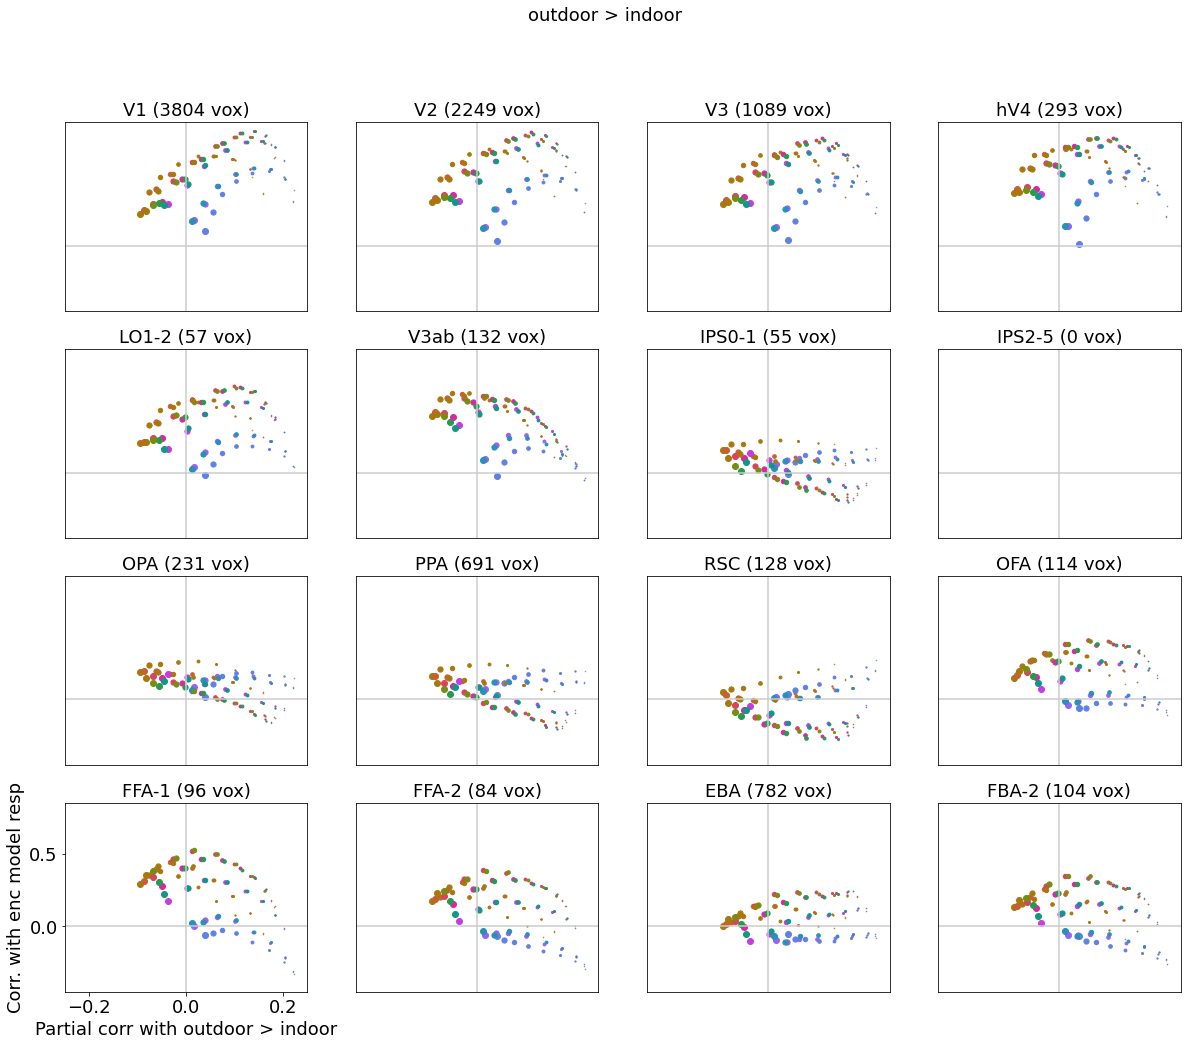

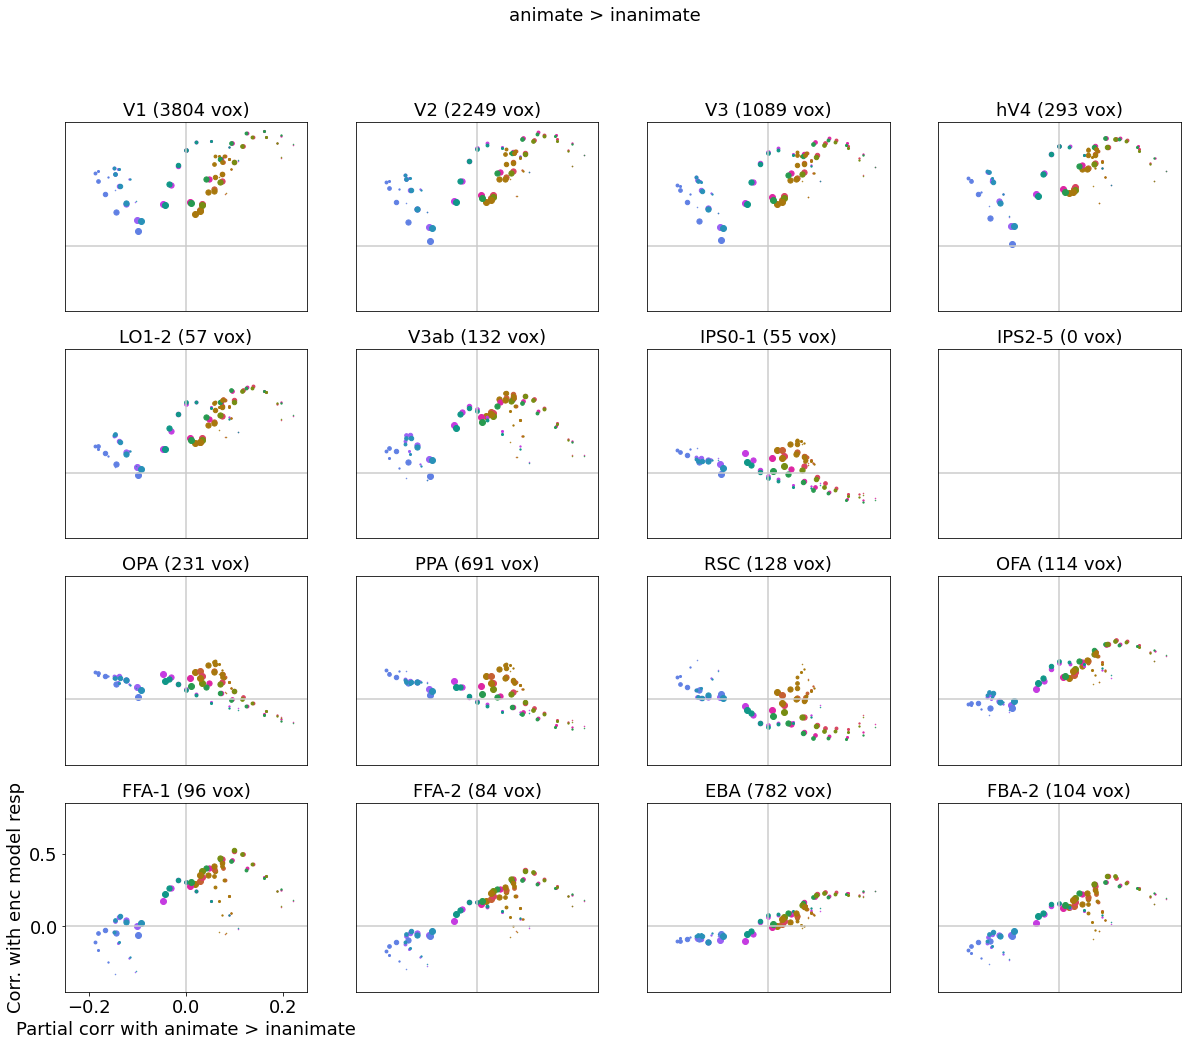

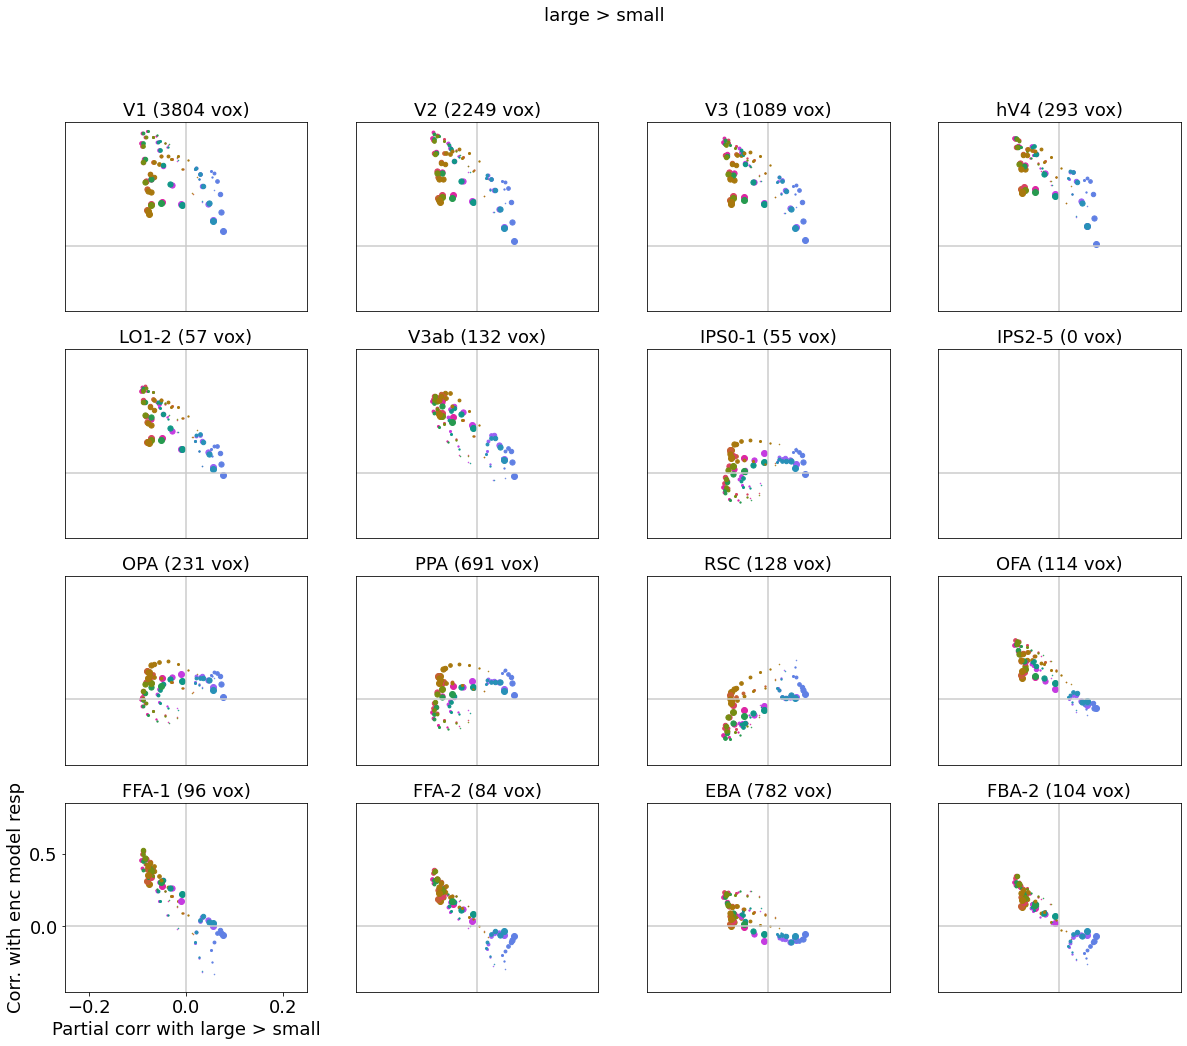

In [8]:
# Plot relationship between feature channels' semantic content, and their correlation w 
# voxel responses in each ROI.

plot_utils.set_all_font_sizes(18)

r2_cutoff = 0.10
val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
abv_thresh = val_r2>r2_cutoff

n_color_steps = n_ori
colors = cmocean.cm.phase(np.linspace(0,1,n_color_steps))

n_size_steps = n_sf
sizes = np.linspace(12,1,n_size_steps)

npx = int(np.ceil(np.sqrt(n_rois)))
npy = int(np.ceil(n_rois/npx))

dorder = [0,1,2]

for dd in dorder:
    
    xvals = np.mean(partial_corr[:,:,dd], axis=1)
    
    xlims = [-0.25, 0.25]
    assert(np.all(xvals<xlims[1]) and np.all(xvals>xlims[0]))
#     xlims = [np.min(xvals)-0.02, \
#              np.max(xvals)+0.02]
    
    ylims = [-0.45, 0.85]
    
    running_ymin = 100; running_ymax = -100
    
    plt.figure(figsize=(20,16))
   
    pi=0

    for rr in range(n_rois):

        inds_this_roi = roi_def.get_indices(rr) & abv_thresh

        pi+=1
        plt.subplot(npx,npy,pi)

        if np.sum(inds_this_roi)>0:   
           
            yvals = np.mean(feature_corr[inds_this_roi,:], axis=0)
            
            assert(np.all(yvals<ylims[1]) and np.all(yvals>ylims[0]))            
            running_ymin = np.minimum(running_ymin, np.min(yvals))
            running_ymax = np.maximum(running_ymax, np.max(yvals))
            
            for oo in range(n_ori):

                for sf in range(n_sf):
                    inds = np.where((ori_inds_list==oo) & (sf_inds_list==sf))[0]
                    plt.plot(xvals[inds], yvals[inds],'.',color=colors[oo,:], markersize=sizes[sf])
                    
        if pi==n_rois-3:
            plt.xlabel('Partial corr with %s'%partial_signed_names[dd])
            plt.ylabel('Corr. with enc model resp')
        else:
            plt.xticks([])
            plt.yticks([])

        plt.axhline(0,color=[0.8, 0.8, 0.8])
        plt.axvline(0,color=[0.8, 0.8, 0.8])
        plt.title('%s (%d vox)'%(roi_names[rr], np.sum(inds_this_roi)))

        plt.xlim(xlims)
        plt.ylim(ylims)

    
    plt.suptitle(partial_signed_names[dd]);
    
#     print([running_ymin, running_ymax])


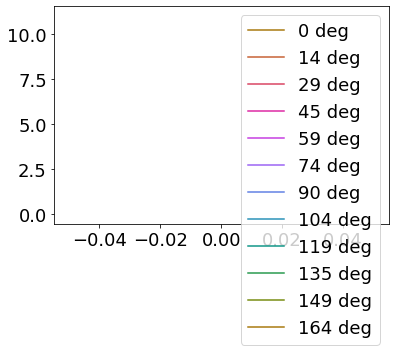

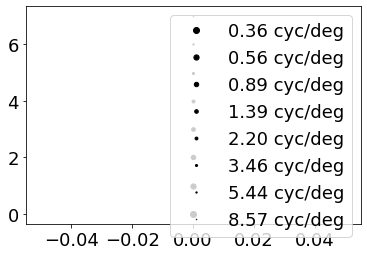

In [10]:
plt.figure();
for oo in range(n_ori):
    plt.plot(0,oo,color=colors[oo,:])    
plt.legend(['%d deg'%ori_unique[oo] for oo in range(n_ori)])

plt.figure();
for sf in range(n_sf):
    plt.plot(0,sf,'.',markersize=sizes[sf],color='k')    
plt.legend(['%.2f cyc/deg'%sf_unique[sf] for sf in range(n_sf)])

[-0.3253024816753513, 0.7853157870295011]


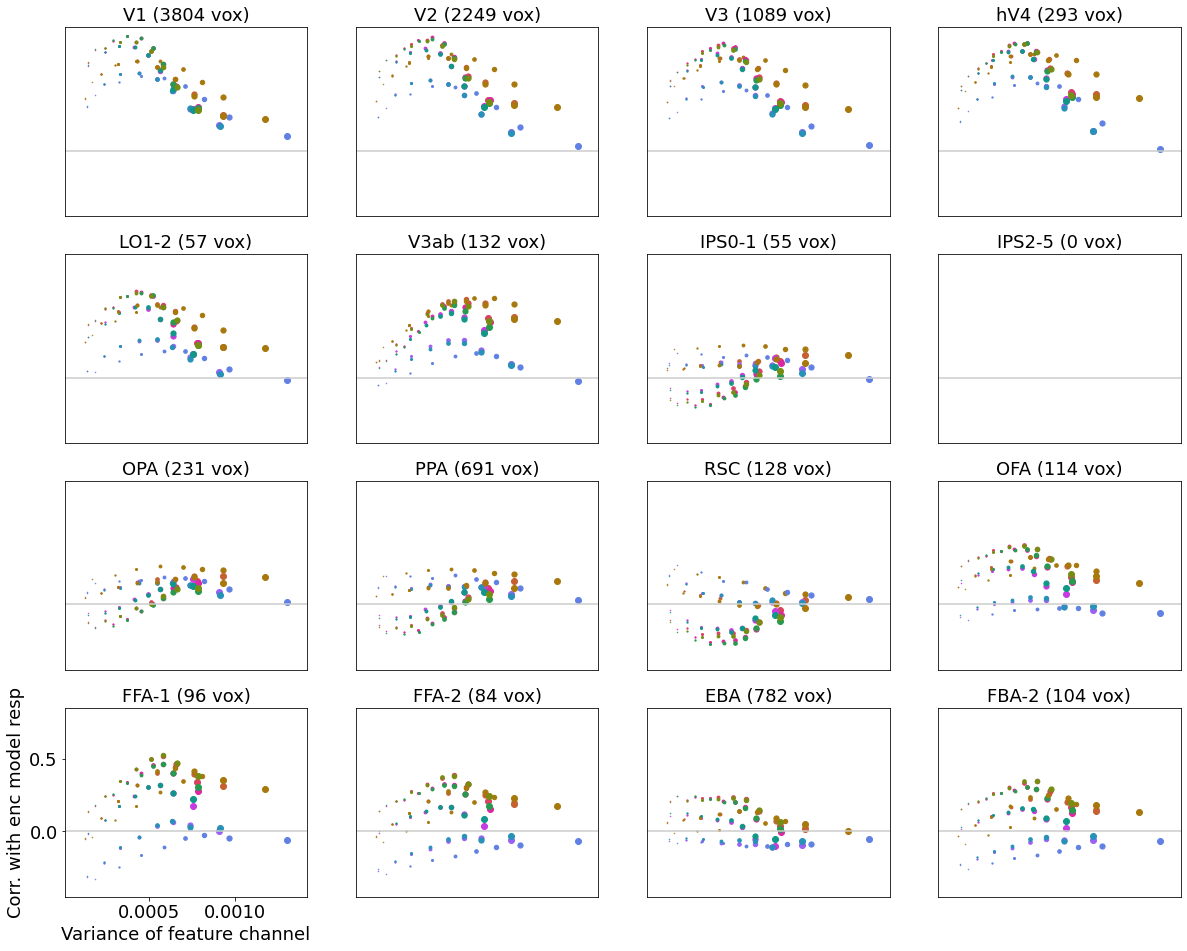

In [11]:
# Plot relationship between feature channels' variance, and their correlation w 
# voxel responses in each ROI.

plot_utils.set_all_font_sizes(18)

r2_cutoff = 0.10
val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
abv_thresh = val_r2>r2_cutoff

n_color_steps = n_ori
colors = cmocean.cm.phase(np.linspace(0,1,n_color_steps))

n_size_steps = n_sf
sizes = np.linspace(12,1,n_size_steps)

npx = int(np.ceil(np.sqrt(n_rois)))
npy = int(np.ceil(n_rois/npx))

xvals = np.mean(var, axis=1)

xlims = [np.min(xvals)-0.10*(np.max(xvals)-np.min(xvals)), \
         np.max(xvals)+0.10*(np.max(xvals)-np.min(xvals))]

ylims = [-0.45, 0.85]

running_ymin = 100; running_ymax = -100

plt.figure(figsize=(20,16))

pi=0

for rr in range(n_rois):

    inds_this_roi = roi_def.get_indices(rr) & abv_thresh

    pi+=1
    plt.subplot(npx,npy,pi)

    if np.sum(inds_this_roi)>0:   

        yvals = np.mean(feature_corr[inds_this_roi,:], axis=0)
        assert(np.all(yvals<ylims[1]) and np.all(yvals>ylims[0]))

        running_ymin = np.minimum(running_ymin, np.min(yvals))
        running_ymax = np.maximum(running_ymax, np.max(yvals))

        for oo in range(n_ori):

            for sf in range(n_sf):
                inds = np.where((ori_inds_list==oo) & (sf_inds_list==sf))[0]
                plt.plot(xvals[inds], yvals[inds],'.',color=colors[oo,:], markersize=sizes[sf])

    if pi==n_rois-3:
        plt.xlabel('Variance of feature channel')
        plt.ylabel('Corr. with enc model resp')    
    else:
        plt.xticks([])
        plt.yticks([])

    plt.axhline(0,color=[0.8, 0.8, 0.8])
    plt.title('%s (%d vox)'%(roi_names[rr], np.sum(inds_this_roi)))

    plt.xlim(xlims)
    plt.ylim(ylims)


print([running_ymin, running_ymax])


[-0.3253024816753513, 0.7853157870295011]


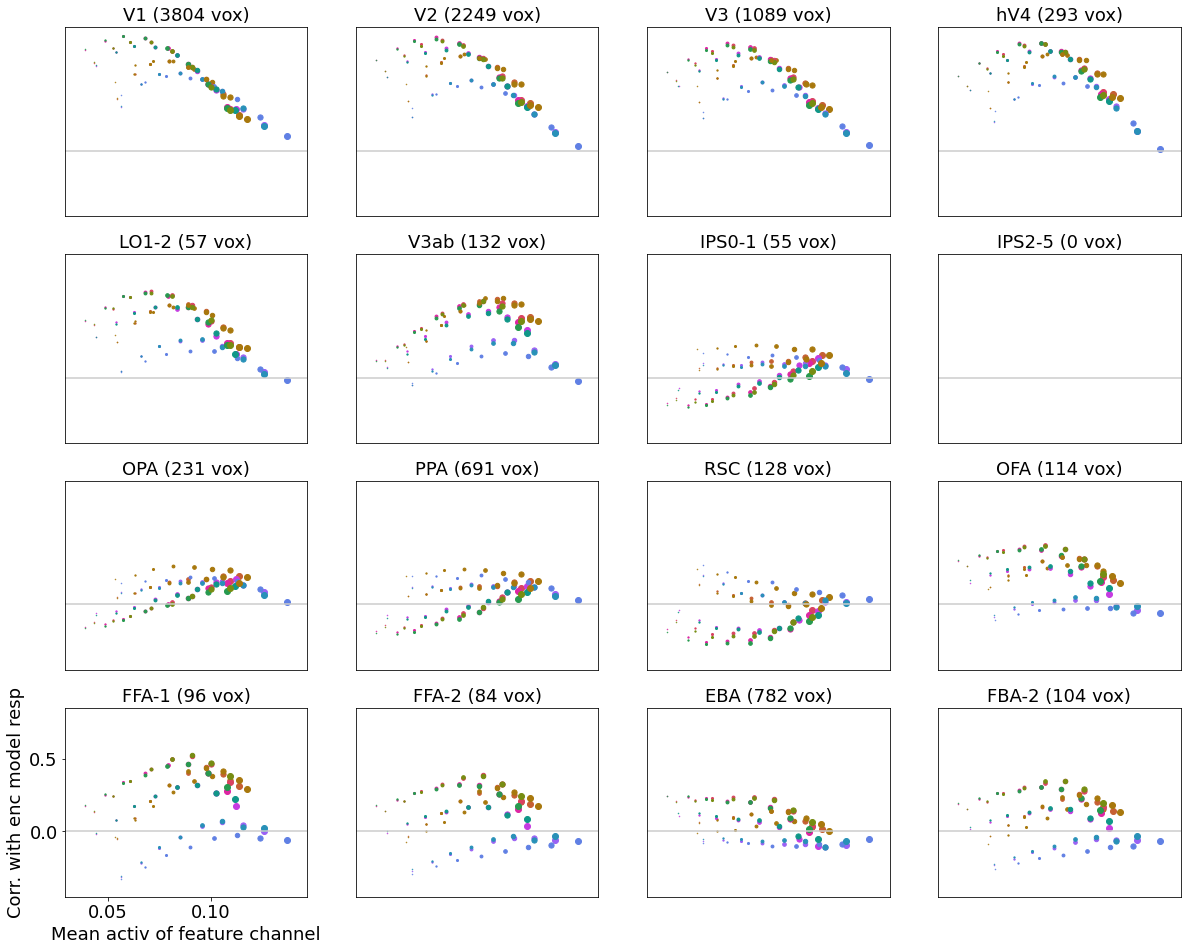

In [12]:
# Plot relationship between feature channels' mean, and their correlation w 
# voxel responses in each ROI.
plot_utils.set_all_font_sizes(18)

r2_cutoff = 0.10
val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
abv_thresh = val_r2>r2_cutoff

n_color_steps = n_ori
colors = cmocean.cm.phase(np.linspace(0,1,n_color_steps))

n_size_steps = n_sf
sizes = np.linspace(12,1,n_size_steps)

npx = int(np.ceil(np.sqrt(n_rois)))
npy = int(np.ceil(n_rois/npx))

xvals = np.mean(mean, axis=1)

xlims = [np.min(xvals)-0.10*(np.max(xvals)-np.min(xvals)), \
         np.max(xvals)+0.10*(np.max(xvals)-np.min(xvals))]

ylims = [-0.45, 0.85]

running_ymin = 100; running_ymax = -100

plt.figure(figsize=(20,16))

pi=0

for rr in range(n_rois):

    inds_this_roi = roi_def.get_indices(rr) & abv_thresh

    pi+=1
    plt.subplot(npx,npy,pi)

    if np.sum(inds_this_roi)>0:   

        yvals = np.mean(feature_corr[inds_this_roi,:], axis=0)
        assert(np.all(yvals<ylims[1]) and np.all(yvals>ylims[0]))

        running_ymin = np.minimum(running_ymin, np.min(yvals))
        running_ymax = np.maximum(running_ymax, np.max(yvals))

        for oo in range(n_ori):

            for sf in range(n_sf):
                inds = np.where((ori_inds_list==oo) & (sf_inds_list==sf))[0]
                plt.plot(xvals[inds], yvals[inds],'.',color=colors[oo,:], markersize=sizes[sf])

    if pi==n_rois-3:
        plt.xlabel('Mean activ of feature channel')
        plt.ylabel('Corr. with enc model resp')    
        
    else:
        plt.xticks([])
        plt.yticks([])

    plt.axhline(0,color=[0.8, 0.8, 0.8])
    plt.title('%s (%d vox)'%(roi_names[rr], np.sum(inds_this_roi)))

    plt.xlim(xlims)
    plt.ylim(ylims)

print([running_ymin, running_ymax])
